# Voynich Manuscript clustering and exploration
## Importing libraries

In [7]:
#https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34
# inspired by ^
import numpy as np 

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from pdf2image import convert_from_path
import cv2

# keras models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from imutils import paths

# standard stack
import matplotlib.pyplot as plt
import pandas as pd

# for everything else
import os
from random import randint
import pickle


# PDF to PNG and JPEG

## TBD: Remove code dupe

## Note: pages removed for flagging as outliers when they were/being pictures of blank pages/metadata (html/title page etc.)

In [8]:
# # Store Pdf with convert_from_path function
# images = convert_from_path('voynich_manuscript.pdf')
 
# for i in range(len(images)):
   
#       # Save pages as images in the pdf
#     images[i].save('./scanned-pages/page'+ str(i) +'.png', 'PNG')

In [9]:
# Store Pdf with convert_from_path function
# path = r""
# # change the working directory to the path where the images are located
# os.chdir(path)

# images = convert_from_path('voynich_manuscript.pdf')
 
# for i in range(len(images)):
   
#       # Save pages as images in the pdf
#     images[i].save('./scanned-jpgs/page'+ str(i) +'.jpeg', 'JPEG')

In [11]:
path = r"../scanned-pages"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
img_list = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            img_list.append(file.name)

In [12]:
img_list[:10]

['page35.png',
 'page21.png',
 'page167.png',
 'page173.png',
 'page198.png',
 'page205.png',
 'page204.png',
 'page199.png',
 'page172.png',
 'page166.png']

In [13]:
len(img_list)

207

In [14]:
img = load_img(img_list[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [15]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [16]:
x = preprocess_input(reshaped_img)

In [31]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [14]:
features = model.predict(reshaped_img)
print(features.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpwml6mt78.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpwml6mt78.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(1, 4096)


In [15]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [16]:
data = {}

# lop through each image in the dataset
for i in img_list:
    # # try to extract the features and update the dictionary
    # try:
    feat = extract_features(i,model)
    data[i] = feat

In [17]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [18]:
filenames

array(['page35.png', 'page21.png', 'page167.png', 'page173.png',
       'page198.png', 'page205.png', 'page204.png', 'page199.png',
       'page172.png', 'page166.png', 'page20.png', 'page34.png',
       'page22.png', 'page36.png', 'page170.png', 'page164.png',
       'page158.png', 'page206.png', 'page207.png', 'page159.png',
       'page165.png', 'page171.png', 'page37.png', 'page23.png',
       'page9.png', 'page27.png', 'page33.png', 'page149.png',
       'page175.png', 'page161.png', 'page203.png', 'page202.png',
       'page160.png', 'page174.png', 'page148.png', 'page32.png',
       'page26.png', 'page8.png', 'page30.png', 'page24.png',
       'page18.png', 'page162.png', 'page176.png', 'page189.png',
       'page200.png', 'page201.png', 'page188.png', 'page177.png',
       'page163.png', 'page19.png', 'page25.png', 'page31.png',
       'page95.png', 'page81.png', 'page56.png', 'page42.png',
       'page104.png', 'page110.png', 'page138.png', 'page139.png',
       'page111.png',

In [19]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(207, 1, 4096)

In [20]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(207, 4096)

## PCA and MinMax Scaling of x

In [21]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [22]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(x)

scaled_features

array([[0.2241406 , 0.5425801 , 0.74882495, ..., 0.30273348, 0.10843387,
        0.50375986],
       [0.07557423, 0.66096073, 0.6357775 , ..., 0.1559475 , 0.461784  ,
        0.54090923],
       [0.35758573, 0.65685815, 0.46063945, ..., 0.1918129 , 0.53887045,
        0.5767461 ],
       ...,
       [0.2077741 , 0.63194263, 0.39880484, ..., 0.27399403, 0.45922765,
        0.12230781],
       [0.2262073 , 0.4863009 , 0.44496953, ..., 0.3244324 , 0.50091326,
        0.84805244],
       [0.47026122, 0.40880215, 0.5130763 , ..., 0.34143114, 0.22673906,
        0.3389805 ]], dtype=float32)

In [23]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


# Choosing K and means-ing it
### https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters

In [24]:
kmeans_kwargs = {
        "n_init": 50,
        "max_iter": 500,
        "random_state": 42,
   }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(x)
   sse.append(kmeans.inertia_)

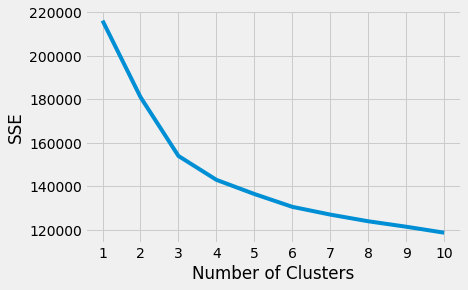

In [25]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

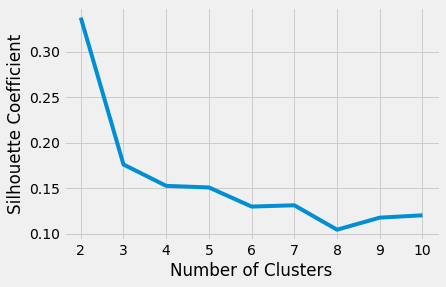

In [26]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(x)
   score = silhouette_score(x, kmeans.labels_)
   silhouette_coefficients.append(score)
   
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [27]:
kl = KneeLocator(
   range(1, 11), sse, curve="convex", direction="decreasing"
   )

kl.elbow

4

In [28]:
kmeans = KMeans(n_clusters=4,n_jobs=-1, random_state=42)
kmeans.fit(x)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=4, n_jobs=-1, random_state=42)

In [29]:
kmeans.labels_

array([1, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 3, 3, 3, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 3, 0, 2,
       2, 2, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 3, 2, 0, 3, 3, 1, 0, 2, 1, 0, 1, 0, 3, 0, 0, 0, 1, 1, 1, 1,
       1, 2, 3, 3, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1,
       0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 2, 3,
       0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 3, 3,
       2, 3, 2, 0, 3, 1, 0, 0, 0], dtype=int32)

## TBD: Turn groups population into function?

In [30]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# TBD: Limit of 30 images is harsh given larger clusters(mess around w/subplots)

In [31]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [32]:
# function that lets you view a cluster (based on identifier)        
def save_cluster(cluster,ind):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig("subplot"+ind)

In [33]:
groups

{1: ['page35.png',
  'page21.png',
  'page172.png',
  'page166.png',
  'page20.png',
  'page22.png',
  'page36.png',
  'page159.png',
  'page165.png',
  'page171.png',
  'page37.png',
  'page23.png',
  'page27.png',
  'page33.png',
  'page160.png',
  'page32.png',
  'page26.png',
  'page8.png',
  'page30.png',
  'page24.png',
  'page18.png',
  'page19.png',
  'page25.png',
  'page31.png',
  'page95.png',
  'page56.png',
  'page42.png',
  'page111.png',
  'page105.png',
  'page43.png',
  'page57.png',
  'page80.png',
  'page94.png',
  'page82.png',
  'page96.png',
  'page55.png',
  'page113.png',
  'page106.png',
  'page54.png',
  'page40.png',
  'page87.png',
  'page93.png',
  'page44.png',
  'page50.png',
  'page78.png',
  'page102.png',
  'page103.png',
  'page79.png',
  'page51.png',
  'page45.png',
  'page92.png',
  'page86.png',
  'page53.png',
  'page101.png',
  'page100.png',
  'page46.png',
  'page52.png',
  'page91.png',
  'page88.png',
  'page77.png',
  'page63.png',
  'page1

In [34]:
for k, v in groups.items():
   print(len(v))

93
57
41
16


## Visualizing the smallest cluster

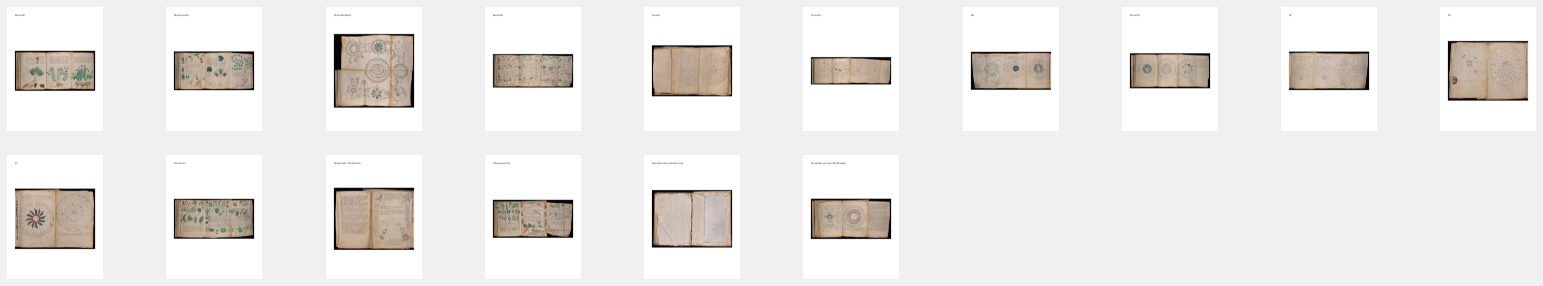

In [35]:
view_cluster(3)

### https://www.pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/

In [36]:
def quantify_image(image, bins=(4, 6, 3)):
	# compute a 3D color histogram over the image and normalize it
	hist = cv2.calcHist([image], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	hist = cv2.normalize(hist, hist).flatten()
	# return the histogram
	return hist

In [37]:
def load_dataset(datasetPath, bins):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []
	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and convert it to the HSV color space
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		# quantify the image and update the data list
		features = quantify_image(image, bins)
		data.append(features)
	# return our data list as a NumPy array
	return np.array(data)

# Isolation Forest for outliers
## TBD: Isolation Forest data prep

In [44]:
data = load_dataset("../scanned-pages", bins=(3, 3, 3))

In [45]:

model = IsolationForest(n_estimators=100,
	random_state=42)
model.fit(data)

IsolationForest(random_state=42)

In [46]:
preds = model.predict(data)

In [47]:
preds 

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [48]:
outliers = np.where(preds==-1)
print(outliers)

(array([ 16,  78, 104, 166, 192]),)


In [49]:
for outlier in outliers[0]:
    print(filenames[outlier])

page158.png
page97.png
page46.png
page5.png
page3.png


# TBD: Show image function here to DRY

(-0.5, 1699.5, 2199.5, -0.5)

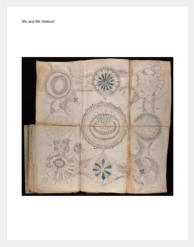

In [50]:
img = load_img("../scanned-pages/"+str(filenames[outliers[0][0]]))
img = np.array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1699.5, 2199.5, -0.5)

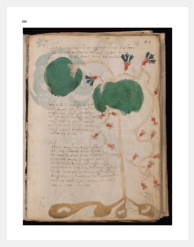

In [51]:
img = load_img("../scanned-pages/"+str(filenames[outliers[0][1]]))
img = np.array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1699.5, 2199.5, -0.5)

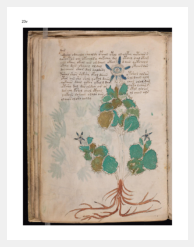

In [52]:
img = load_img("../scanned-pages/"+str(filenames[outliers[0][2]]))
img = np.array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1699.5, 2199.5, -0.5)

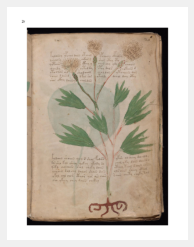

In [53]:
img = load_img("../scanned-pages/"+str(filenames[outliers[0][3]]))
img = np.array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1699.5, 2199.5, -0.5)

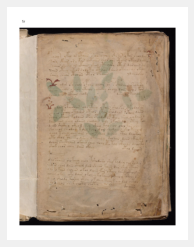

In [54]:
img = load_img("../scanned-pages/"+str(filenames[outliers[0][4]]))
img = np.array(img)
plt.imshow(img)
plt.axis('off')

# SIFT keypoint detection and FLANN from open-cv docs

# TBD: More functions,,,

In [55]:
img = cv2.imread("../scanned-pages/page46.png")
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('../outlier_keypoints.jpg',img)

True

In [56]:
outlier_cluster = groups.get(0)

outlier_cluster

['page167.png',
 'page173.png',
 'page34.png',
 'page206.png',
 'page207.png',
 'page9.png',
 'page175.png',
 'page161.png',
 'page174.png',
 'page176.png',
 'page177.png',
 'page163.png',
 'page81.png',
 'page104.png',
 'page110.png',
 'page69.png',
 'page107.png',
 'page112.png',
 'page68.png',
 'page97.png',
 'page83.png',
 'page117.png',
 'page90.png',
 'page84.png',
 'page47.png',
 'page129.png',
 'page114.png',
 'page128.png',
 'page85.png',
 'page118.png',
 'page76.png',
 'page60.png',
 'page132.png',
 'page127.png',
 'page133.png',
 'page75.png',
 'page70.png',
 'page64.png',
 'page134.png',
 'page135.png',
 'page67.png',
 'page73.png',
 'page98.png',
 'page6.png',
 'page14.png',
 'page7.png',
 'page179.png',
 'page144.png',
 'page150.png',
 'page4.png',
 'page168.png',
 'page182.png',
 'page3.png',
 'page181.png',
 'page38.png',
 'page10.png',
 'page2.png']

## TBD: Add array of (top N limited?) matched images to loop over and display, functionalize

In [58]:
train_image = cv2.imread('../scanned-pages/page46.png',cv2.IMREAD_GRAYSCALE) # image to be queried
# Initiate SIFT detector
sift = cv2.SIFT_create()

highest_match = 0
matched_image = None
for i in outlier_cluster:
    query_image = cv2.imread("../scanned-pages/" + str(i),cv2.IMREAD_GRAYSCALE)          # image to query for in train image
# find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(query_image,None)
    kp2, des2 = sift.detectAndCompute(train_image,None)
# FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    if len(matches) > highest_match:
        highest_match = len(matches)
        matched_image = i 
        print(f"New match: {i} with {highest_match} matches as highest match count")
print(f"{matched_image} is the final closest matched image")

New match page167.png with 11737 as highest match
New match page173.png with 12510 as highest match
New match page175.png with 17662 as highest match
New match page176.png with 19315 as highest match
New match page135.png with 22489 as highest match
page135.png is the matched image


In [59]:
matched_image

'page135.png'

In [62]:
query_image = cv2.imread("../scanned-pages/" + str(matched_image),cv2.IMREAD_GRAYSCALE)

query_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

# Most similar image compared to interesting outlier image

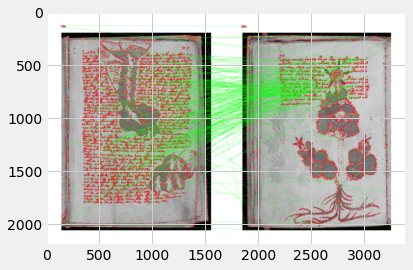

In [63]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(query_image,None)
kp2, des2 = sift.detectAndCompute(train_image,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
    
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
result_img = cv2.drawMatchesKnn(query_image,kp1,train_image,kp2,matches,None,**draw_params)
plt.imshow(result_img,),plt.show()
plt.imsave("../four_cluster_outlier.png", result_img)

# Visualizing VGG16 layers/feature maps
## https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [22]:
from keras.models import Model
from numpy import expand_dims

In [ ]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


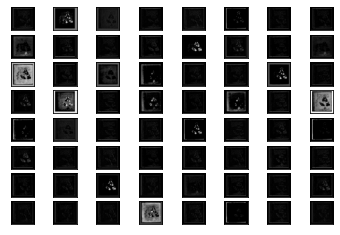

In [58]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('../scanned-pages/page46.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.savefig("first_layer.png")
plt.show()

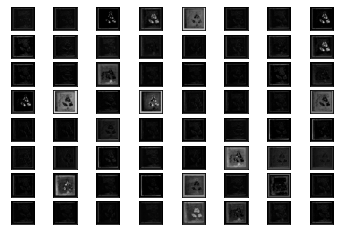

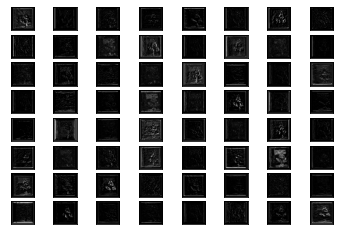

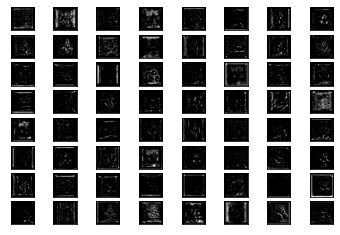

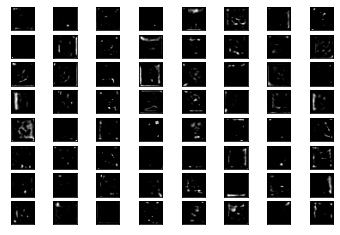

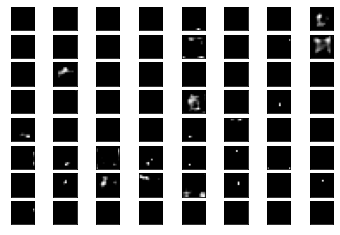

In [57]:
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('../scanned-pages/page46.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
			# specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
			# plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
	# show the figure
    plt.show()